#### CMSE 202 Final Project
### &#9989; Chris Brown, Kewalin Samart, Jay Scott, Raymond Smith
### &#9989; Section_003
#### &#9989; 4/13/21

# ___Modeling Oxygen Repopulation in Blood Cells___

## Background and Motivation

__**__

## Methodology

In [2]:
import numpy as np
import pandas as pd
import math
import random
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
%matplotlib inline

### Pseudocode

__*Focusing on modeling blood moving through veins/arteries. Possibly model a smaller process, oxygen from lungs to blood*__

1) Initialize a board- Put oxygen, blood cells, and organs on the board. Veins/arteries represented by straight line boundaries on board. Put veins and arteries on the board with junctions. Organs should occupy multiple grid points and be initialized containing CO2

2) Use classes to represent oxygen, blood cell/hemoglobin, and organs.

    Attributes/Methods
    
    Oxygen; Able to be transferred from blood to organs. (For smaller model)Oxygen is able to diffuse from lungs to blood stream. Oxygen randomly appears every few time steps to represent breathing. Most oxygen must be carried by blood cells/hemoglobin. A percentage of oxygen dissolves/diffuses into plasma which contains blood cells. 3% of oxygen will be randomly chosen to move randomly through plasma alongside blood cells.
    
    Blood Cells/Hemoglobin; Randomly assign blood cells at start to have oxygen or CO2. Blood cells have two different states, full of oxygen and full of CO2. Moves radomly through veins and arteries, at junctions we can set different probabilities for which path a blood cell might take. Blood cells check every grid point around them (nearest neighbor function) for vein/artery paths. Blood cells carrying CO2 only travel through veins and cells carrying oxygen only travel through arteries.
    
    Organs; Organs contain CO2 when initialized with the board. Absorb oxygen and create CO2. When oxygen reaches an organ it is turned into CO2 and leaves the organ. When CO2 reaches the lungs we somehow show it being expelled from the body (it disappears from the model)



### Actual Code

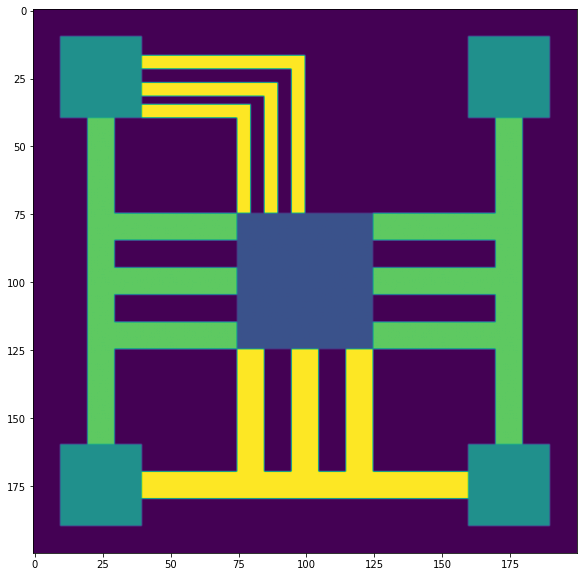

In [44]:
board = np.zeros(shape = (200,200)) # Initializing a 100 by 100 size board of color purple

board[75:125,75:125] = 1 # Representing a lung as a 20 by 20 square on the board

# Organs - teal
board[160:190, 160:190] = 2 # Representing an organ as a 10 by 10 square on the board
board[10:40, 10:40] = 2 # Representing an organ as a 10 by 10 square on the board
board[10:40, 160:190] = 2 # Representing an organ as a 10 by 10 square on the board
board[160:190, 10:40] = 2 # Representing an organ as a 10 by 10 square on the board

# Arteries - green
board[40:160,20:30] = 3 
board[40:160, 170:180] = 3 
board[95:105,28:75] = 3 
board[95:105,125:170] = 3
board[115:125,28:75] = 3 
board[75:85,28:75] = 3 
board[75:85,125:170] = 3 
board[115:125,125:170] = 3 

# Veins - yellow
board[35:40,40:75] = 4 # left top sideways peg
board[170:180,40:160] = 4 
board[27:75,85:90] = 4 # middle top upright peg
board[27:32,40:90] = 4 # middle top sideways peg
board[125:178,95:105] = 4 
board[20:75,95:100] = 4 # right top upright peg
board[17:22,40:100] = 4 # right top sideways peg
board[35:75,75:80] = 4 # left top upright peg
board[125:170,75:85] = 4 
board[125:175,115:125] = 4 

# plotting the board
plt.figure(figsize=(20,10))
plt.imshow(board) 